In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, Model

# 1. Load dataset


In [2]:
IMG_SIZE = (224, 224)  # EfficientNetB0 expects 224×224 by default :contentReference[oaicite:2]{index=2}
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

In [3]:
(ds_train, ds_val), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True,
    with_info=True
)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/incomplete.2N6PF7_4.0.1/cats_vs_dogs-train.tfrecord*...:   0%…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.


In [6]:
def preprocess(image, label):
    # Resize and normalize — EfficientNet expects standard scaling
    image = tf.image.resize(image, IMG_SIZE)
    image = image / 255.0
    return image, label

In [7]:
train_ds = ds_train.map(preprocess).shuffle(1000).batch(BATCH_SIZE).prefetch(AUTOTUNE)
val_ds   = ds_val.map(preprocess).batch(BATCH_SIZE).prefetch(AUTOTUNE)


# 2. Build model with EfficientNetB0 base

In [13]:
base_model = tf.keras.applications.EfficientNetB0(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # freeze base layers initially

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


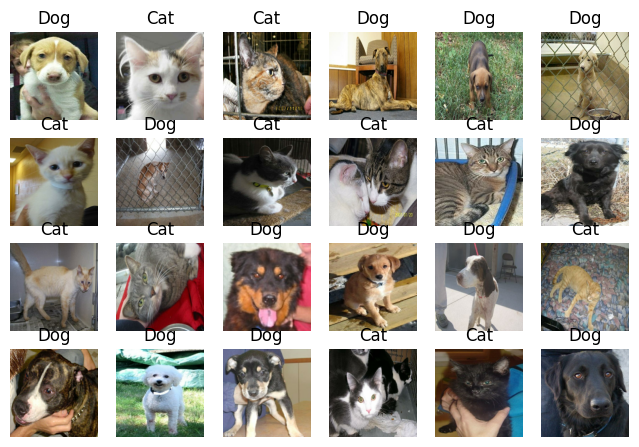

In [8]:
import matplotlib.pyplot as plt

for images, labels in train_ds.take(1):
    plt.figure(figsize=(8,8))
    for i in range(24):
        ax = plt.subplot(6,6,i+1)
        plt.imshow(images[i])
        plt.title("Dog" if labels[i]==1 else "Cat")
        plt.axis("off")
    plt.show()

In [14]:
# Add custom classification head
inputs = tf.keras.Input(shape=IMG_SIZE + (3,))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

# -------- 4) Build the CNN model --------
# We'll include augmentation and a normalization layer as part of the model for clarity.


In [15]:
model = Model(inputs, outputs)

In [17]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [18]:

model.summary()

# 3. Train (feature‑extraction phase)
EPOCHS = 5  # start small to test
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,050,852 (15.45 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

Epoch 1/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 104s 126ms/step - accuracy: 0.4984 - loss: 0.6982 - val_accuracy: 0.5097 - val_loss: 0.6931
Epoch 2/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 43s 72ms/step - accuracy: 0.4910 - loss: 0.6982 - val_accuracy: 0.5099 - val_loss: 0.6930
Epoch 3/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 42s 71ms/step - accuracy: 0.4980 - loss: 0.6969 - val_accuracy: 0.5099 - val_loss: 0.6930
Epoch 4/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 39s 66ms/step - accuracy: 0.4981 - loss: 0.6979 - val_accuracy: 0.5099 - val_loss: 0.6929
Epoch 5/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 41s 65ms/step - accuracy: 0.5066 - loss: 0.6964 - val_accuracy: 0.5099 - val_loss: 0.6929


# -------- 7) Train --------

In [19]:

# 4. Evaluate
loss, acc = model.evaluate(val_ds)
print("Validation accuracy (feature-extraction):", acc)

146/146 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.5124 - loss: 0.6929
Validation accuracy (feature-extraction): 0.509888231754303


# -------- 8) Evaluate --------

In [20]:
# 5. Fine-tune some layers (optional, careful)
base_model.trainable = True
# Freeze first few layers if you want
for layer in base_model.layers[:100]:
    layer.trainable = False


# -------- 9) Visualize training curves --------

In [21]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

fine_epochs = 3
history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=fine_epochs
)

loss, acc = model.evaluate(val_ds)
print("Validation accuracy (after fine‑tuning):", acc)


Epoch 1/3
582/582 ━━━━━━━━━━━━━━━━━━━━ 138s 153ms/step - accuracy: 0.5712 - loss: 0.6759 - val_accuracy: 0.6442 - val_loss: 0.6290
Epoch 2/3
582/582 ━━━━━━━━━━━━━━━━━━━━ 56s 94ms/step - accuracy: 0.6441 - loss: 0.6228 - val_accuracy: 0.6348 - val_loss: 0.6397
Epoch 3/3
582/582 ━━━━━━━━━━━━━━━━━━━━ 55s 92ms/step - accuracy: 0.6794 - loss: 0.5834 - val_accuracy: 0.7053 - val_loss: 0.5780
146/146 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - accuracy: 0.7124 - loss: 0.5746
Validation accuracy (after fine‑tuning): 0.7052880525588989


# -------- 10) Predict on a few validation images and show results --------

# -------- 11) Save final mode--------

In [22]:
model.save("cats_vs_dogs_model.keras")




In [23]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls -lh


1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


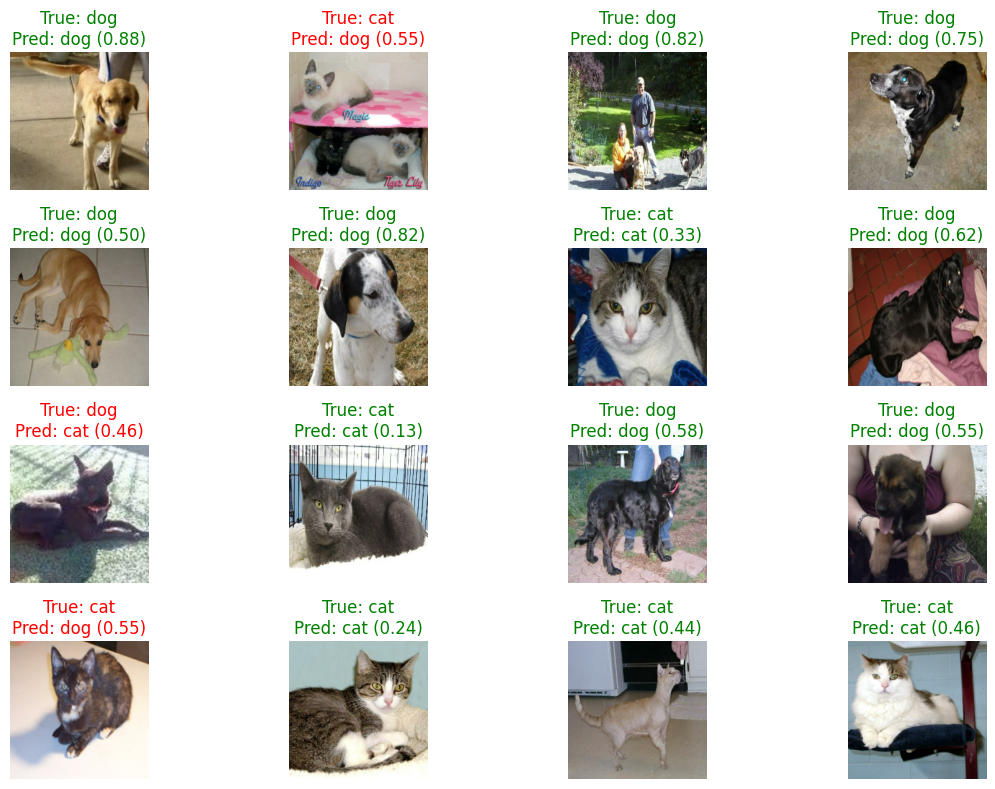

In [24]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Suppose your validation dataset pipeline is called val_ds (as before)
class_names = ["cat", "dog"]

# 1) Get one batch of images from validation set
for images, labels in val_ds.take(1):  # take 1 batch
    preds = model.predict(images)  # predictions (probabilities)
    probs = preds.flatten()
    # probs[i] is probability of class "dog" (since sigmoid output)

    plt.figure(figsize=(12, 8))
    for i in range(min(16, len(images))):  # show first 16 images
        ax = plt.subplot(4, 4, i + 1)
        img = images[i].numpy()
        plt.imshow(img)
        true = class_names[int(labels[i].numpy())]
        pred = class_names[int(probs[i] >= 0.5)]
        confidence = probs[i]
        plt.title(f"True: {true}\nPred: {pred} ({confidence:.2f})",
                  color=("green" if true == pred else "red"))
        plt.axis("off")
    plt.tight_layout()
    plt.show()
    break
